In [1]:
from astropy.timeseries import LombScargle
import numpy as np
import pandas as pd
import time
from astropy import time, coordinates as coord, units as u
import matplotlib.pyplot as plt

In [2]:
from lk_stat_package import lk_stat

In [3]:
def correct_time(df,mjd_col,ra_col,dec_col,site='saao'):
    ip_peg = coord.SkyCoord(df[ra_col].values,df[dec_col].values,
                            unit=(u.deg, u.deg), frame='icrs')
    saao = coord.EarthLocation.of_site(site)
    times = time.Time(list(df[mjd_col]), format='mjd',
                      scale='tt', location=saao) 
    ltt_bary = times.light_travel_time(ip_peg,'barycentric')  
    time_barycentre = times.tdb + ltt_bary
    df.loc[:,'bct']=time_barycentre.jd
    
    return df

In [4]:
def freq_grid(times,oversampling_factor,f0=None,fn=None):
    times=np.sort(times)
    tbase=(times.max() - times.min())
    df = 1.0 / tbase
    if f0 is None:
        f0 = df
    if fn is None:
        fn = 0.5 / np.mean(np.diff(times)) 
    return np.arange(f0, fn, 1/(tbase * oversampling_factor))

In [5]:
def remove_outliers(df,filters,mag_col,filter_col,magerr_col1,magerr_col2=None):
    dframe=pd.DataFrame()
    for Filter in filters:
        
        temp=df[df[filter_col]==Filter]
        if magerr_col2==None:
            err=df[magerr_col1].values
            temp['mag_err']=err
        else:
            err_1=df[magerr_col1].values
            err_2=df[magerr_col2].values
            err=np.sqrt((err_1**2) + (err_2**2))
            temp['mag_err']=err
        
        q3_err, q1_err = np.percentile(err, [75 ,25])
        iqr_err=q3_err-q1_err
        h_err=q3_err+iqr_err*1.5
            
        temp=temp[temp['mag_err']<=h_err]
                
        dframe=pd.concat([dframe,temp])
        
    return dframe

In [28]:
data=pd.read_csv("5829829973018664448_ml.csv")

In [29]:
data.columns

Index(['ra', 'dec', 'NUMBER_IN', 'FILENAME', 'X_POS', 'Y_POS', 'MJD-OBS',
       'OBJECT', 'FILTER', 'EXPTIME', 'S-SEEING', 'AIRMASS', 'PC-ZP',
       'PC-ZPSTD', 'QC-FLAG', 'FLAGS_MASK', 'BACKGROUND', 'MAG_OPT',
       'MAGERR_OPT', 'SNR_OPT', 'LIMMAG_OPT', 'FNU_OPT', 'FNUERR_OPT',
       'MAG_APER_R0.66xFWHM', 'MAGERR_APER_R0.66xFWHM', 'SNR_APER_R0.66xFWHM',
       'FNU_APER_R0.66xFWHM', 'FNUERR_APER_R0.66xFWHM', 'MAG_APER_R1.5xFWHM',
       'MAGERR_APER_R1.5xFWHM', 'SNR_APER_R1.5xFWHM', 'FNU_APER_R1.5xFWHM',
       'FNUERR_APER_R1.5xFWHM', 'MAG_APER_R5xFWHM', 'MAGERR_APER_R5xFWHM',
       'SNR_APER_R5xFWHM', 'FNU_APER_R5xFWHM', 'FNUERR_APER_R5xFWHM'],
      dtype='object')

In [30]:
data['QC-FLAG'].value_counts()

QC-FLAG
yellow    3426
orange    1312
green      120
Name: count, dtype: int64

In [31]:
data=data[data['QC-FLAG']!="red"]

In [32]:
data['FILTER'].value_counts()

FILTER
q    1728
u    1680
i    1450
Name: count, dtype: int64

In [11]:
dataq=data[data['FILTER']=='q']

In [12]:
dataq=correct_time(dataq,mjd_col='MJD-OBS',ra_col='ra',dec_col='dec',site='saao')

/tmp/ipykernel_3432329/3659649405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'bct']=time_barycentre.jd


In [13]:
dataq.iloc[:,-1:].columns

Index(['bct'], dtype='object')

In [14]:
rm_outliers=True
if rm_outliers:
    dataq_clean=remove_outliers(dataq,filters='q',mag_col='MAG_OPT',
                            filter_col='FILTER',magerr_col1='MAGERR_OPT',magerr_col2='PC-ZPSTD')
else: 
    dataq['mag_err']=np.sqrt(data['MAGERR_OPT']**2+data['PC-ZPSTD']**2)
    data_clean=dataq

In [15]:
dataq_clean.iloc[:,-2:].columns

Index(['bct', 'mag_err'], dtype='object')

In [16]:
dataq_clean['FILTER'].value_counts()

FILTER
q    1717
Name: count, dtype: int64

In [17]:
mag=dataq_clean['MAG_OPT'].values
magerr=dataq_clean['mag_err'].values
Time=dataq_clean['bct'].values
Time=Time - np.median(Time)

In [18]:
frequencies=freq_grid(times=Time, oversampling_factor=5,
                                      f0=None,fn=50)
                
                      
periods=1/frequencies

In [19]:
frequencies.shape

(482461,)

In [20]:


lsp = LombScargle(t=Time, y=mag, dy=magerr,nterms=1).power(frequency=frequencies, method="cython", normalization="psd")


theta=lk_stat(periods,mag,magerr,Time)


psi=(2*lsp)/theta



In [22]:
psi_norm=psi/psi.max()
best_freq=frequencies[np.argmax(psi_norm)]
period_est=1/best_freq
qphase=(Time/period_est)%1

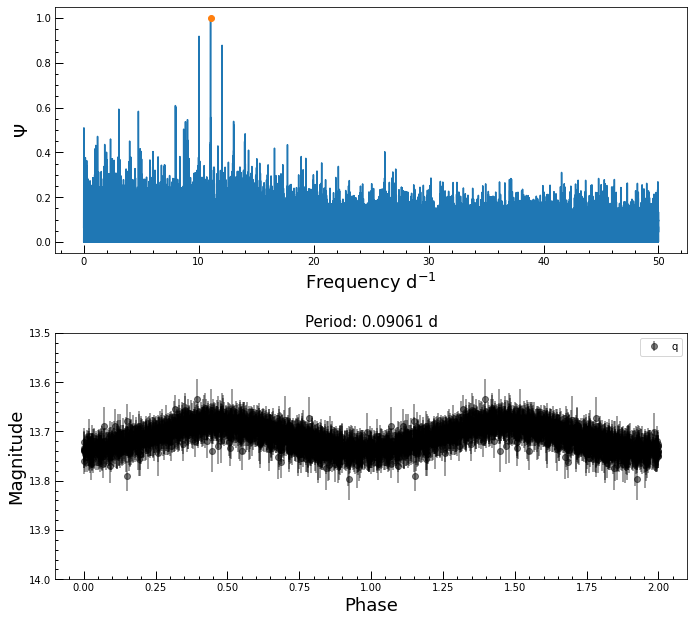

In [39]:
fig = plt.figure(figsize=[10,9])

ax = fig.add_subplot(2, 1, 1)

ax.plot(frequencies,psi_norm)

ax.set_xlabel(r'Frequency $\rm d^{-1}$',fontsize=18)
ax.set_ylabel(r'$\Psi$',fontsize=18)
ax.plot(best_freq,psi_norm.max(),'o')
ax.minorticks_on()
ax.tick_params('both', length=8, width=1., which='major', direction='in')
ax.tick_params('both', length=3, width=1, which='minor', direction='in')

ax = fig.add_subplot(2, 1, 2)

ax.set_title('Period: %.5f d'%(period_est),fontsize=15)
ax.errorbar(qphase,mag,yerr=magerr,fmt='ok',alpha=0.5,label='q')
ax.errorbar(qphase+1,mag,yerr=magerr,fmt='ok',alpha=0.5)
ax.set_ylim([13.5,14])
ax.set_ylabel('Magnitude',fontsize=18)
ax.set_xlabel('Phase',fontsize=18)

ax.legend(loc='best',fontsize=15)
            
ax.minorticks_on()
ax.tick_params('both', length=8, width=1., which='major', direction='in')
ax.tick_params('both', length=3, width=1, which='minor', direction='in')
ax.legend()
plt.tight_layout(pad=2)
plt.gca().invert_yaxis()
